# Stochastic Optimization using inferred model

Condider a problem where you have to perform optimization for decision making. You don't know about the world very much and thus you have to do bayesian inference to discover it.

This formulation covers a wide range of practical tasks, here are some of them:
 * Maximizing stochastic output of model $E_{p(\theta|D)}[f(X)] \rightarrow max X$
 * Minimizing costs of inputs to archive target $E_{p(y|X, \theta, D)}[L(y_{target}, X, y)] \rightarrow min X$
 * Minimizing Bayesian risk: $E_{p(y|X, \theta, D)}[L(y_p, y)] \rightarrow min y_p$


In [1]:
%matplotlib inline
import functools
import numpy as np
from theano import theano, tensor as tt
import matplotlib.pyplot as plt
import pymc3 as pm
np.random.seed(42)

## Quadratic problem
Consider a simple quadratic problem with unknown parameters. Here comes Bayesian inference to get model with that we need for our opimization

In [2]:
def f(x, a, b, c):
    return a*x**2 + b*x + c

### True data
Generate true data

In [3]:
x_obs = np.random.uniform(-5, 5, size=(15,)).astype('float32')
a, b, c = 1, 2, 3
min_ = np.array([-b/2/a])
y_obs = f(x_obs, a, b, c) + np.random.normal(size=x_obs.shape).astype('float32')

### Final task
Our task is to find th minimum of the unknown function without evaluating it. That differs a lot from traditional Bayesian optimization using Gaussian Process. Here we have to deal with uncertainty in loss.

Now let's look at true optima

In [4]:
min_

array([-1.])

And at the data

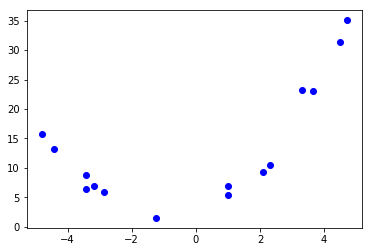

In [5]:
plt.plot(x_obs, y_obs, 'bo');

For inference you can use every method you like. Here I use SVGD just to show that it's result can be used in inferece as well as any other tool in variational module.

In [6]:
sgd = functools.partial(pm.sgd, learning_rate=.001) # simple problem - simple optimizer
with pm.Model() as model:
    abc = pm.Normal('abc', sd=1, shape=(3,))
    x = theano.shared(x_obs, 'x_obs')
    x2 = x**2
    o = tt.ones_like(x)
    X = tt.stack([x2, x, o]).T
    y = X.dot(abc)
    pm.Normal('y', mu=y, observed=y_obs)
    histogram = pm.fit(4000, method='svgd', obj_optimizer=sgd)
    # or like that if you want to customize SVGD
    # svgd = pm.SVGD(n_particles=500, jitter=.1)
    # histogram = svgd.fit(1000, obj_optimizer=sgd)

WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
100%|██████████| 4000/4000 [00:24<00:00, 166.11it/s]


As a result we have a `Histogram` instance. Histogram is a linkage from raw samples to theano computational engine. If we use NUTS for example there is no direct way to use trace results in computational stuff except Histogram, we'll see it later.

In [7]:
histogram

In [8]:
histogram.histogram.get_value().mean(0)

array([ 1.0527544 ,  1.99613583,  1.92554891], dtype=float32)

It contains particles inferred with SVGD, shared variable has exactly 100 samples for 3 variables.

In [9]:
type(histogram.histogram), histogram.histogram.get_value().shape

(theano.tensor.sharedvar.TensorSharedVariable, (100, 3))

Here is an option to use NUTS for inference and reuse it's trace directly in optimization. Let's do it!

In [10]:
with model:
    step = pm.NUTS()
    trace = pm.sample(10000, step=step)

/root/macos/dev/pymc3/pymc3/sampling.py:188: UserWarning: Instantiated step methods cannot be automatically initialized. init argument ignored.
  warnings.warn('Instantiated step methods cannot be automatically initialized. init argument ignored.')
100%|██████████| 10000/10000 [00:20<00:00, 487.37it/s]


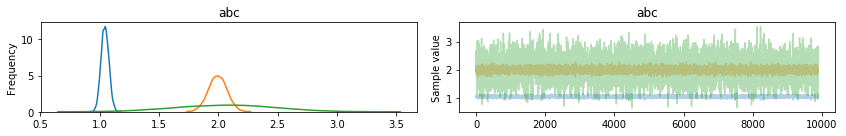

In [11]:
pm.traceplot(trace[100:]);

In [12]:
trace

<MultiTrace: 1 chains, 10000 iterations, 1 variables>

In [13]:
histogram = pm.Histogram(trace[100:], model=model)
histogram

In [14]:
histogram.histogram.get_value().shape

(9900, 3)

# Inference results

We don't have exact function as our observations were noisy

In [15]:
histogram.histogram.get_value().mean(0)

array([ 1.04420257,  1.99506605,  2.05719256], dtype=float32)

In [18]:
isinstance(histogram, pm.variational.opvi.Approximation)

True

Basicly, any subclass of `pm.variational.opvi.Approximation` __must__ implement some abstract methods. One required is `.random(size)`. That allows to create unified interface for _any_ approximation we get from inference and reuse it just everywhere.

The most frequent case is to create stochastic function and all we know about it is that it has PyMC3 variables with somehow inferred distribution. That is pretty easy with `Approximation` class. There are two great methods for that:

* `.apply_replacements(node or list of nodes, ...)`
```
    Replace variables in graph with variational approximation. By default, replaces all variables

    Parameters
    ----------
    node : Theano Variable(s)
        node or nodes for replacements
    deterministic : bool
        whether to use point with highest density as initial point for distribution
        if True - constant initial point will produce constant latent variables
    include : list
        latent variables to be replaced
    exclude : list
        latent variables to be excluded for replacements
    more_replacements : dict
        add custom replacements to graph, e.g. change input source

    Returns
    -------
    node(s) with replacements
```

* `.sample_node(node or nodes, ...)`

```
    Samples given node or nodes over shared posterior

    Parameters
    ----------
    node : Theano Variable(s)
    size : scalar
        number of samples
    more_replacements : dict
        add custom replacements to graph, e.g. change input source

    Returns
    -------
    sampled node(s) with replacements
```

In [22]:
histogram.apply_replacements(y, deterministic=True).eval()

array([ 18.1869278 ,  16.50654984,  14.91315365,  13.40673256,
        11.98729515,  10.65483952,   9.4093647 ,   8.25086784,
         7.17935371,   6.19481897,   5.29726696,   4.48669481,
         3.76310253,   3.12649107,   2.57685995,   2.11421013,
         1.73854065,   1.44985199,   1.24814403,   1.13341665,
         1.10566974,   1.16490352,   1.31111813,   1.54431319,
         1.86448908,   2.27164555,   2.76578259,   3.34690046,
         4.01499891,   4.77007771,   5.61213732,   6.54117775,
         7.557199  ,   8.66020012,   9.85018349,  11.12714481,
        12.49108982,  13.94201374,  15.47992039,  17.10480499,
        18.81666946,  20.61551666,  22.50134277,  24.47415543,
        26.53393936,  28.68070984,  30.91445923,  33.23519516,
        35.64290237,  38.13759232], dtype=float32)

# Picture
Let's look at what we got from inference. There will be mean function.

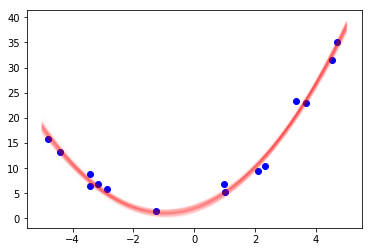

In [23]:
x.set_value(np.linspace(-5, 5, dtype='float32'))
plt.plot(x_obs, y_obs, 'bo');
y_dist = histogram.sample_node(y).eval()
for line in y_dist:
    plt.plot(np.linspace(-5, 5), line, 'r-', alpha=.02);

We need an optima for real function but we know only we distribution over possible functions. To find the minima we can get the minimum of expected function. It can be done out of the box with PyMC3 tools.

# Optimization
At first we must create someting we wrt want to minimize and what to minimize. In our problem it is `x` coordinate. 

In [24]:
# wrt what to minimize
# set x far from optima
x_ = theano.shared(pm.floatX(10.), 'x')
# and what to minimize
# Notice that we use random variable in out loss so it bocomes stochastic
y_ = f(x_ ,abc[0], abc[1], abc[2])

In [25]:
N = 2000
hist_x = np.empty(N)
def cb(approx, current_loss, i):
    hist_x[i] = x_.get_value()

In [26]:
sgd = functools.partial(pm.sgd, learning_rate=.001)
opt = pm.Optimizer(histogram, y_, [x_], optimizer=sgd)
opt.fit(N, callbacks=[cb])

E_q[Loss] = 1.1633: 100%|██████████| 2000/2000 [00:00<00:00, 20250.94it/s]


# Optimization results
It's all right!

In [27]:
x_.get_value(), min_

(array(-0.7868053913116455, dtype=float32), array([-1.]))

# Loss history

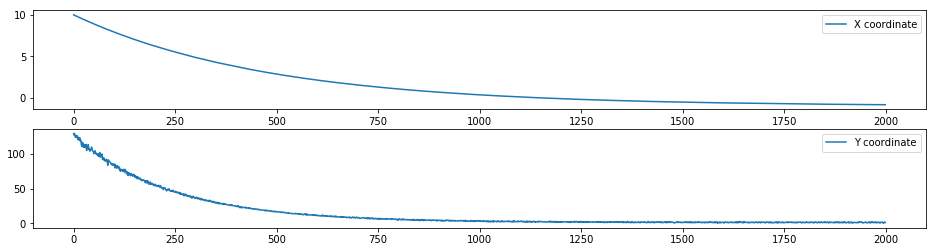

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(16, 4))
ax[0].plot(hist_x, label='X coordinate');
ax[1].plot(opt.hist, label='Y coordinate');
ax[0].legend();
ax[1].legend();